In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import randn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
data = pd.read_csv('diabetes.csv')
print (data.shape)
print (data.tail())
print (data.columns)

(768, 9)
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
label = ['Outcome']
X = data[features]
y = data[label]

In [ ]:
X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)
clf_true = RandomForestClassifier(n_estimators=100)
clf_true.fit(X_true_train,y_true_train)
y_true_pred=clf_true.predict(X_true_test)
print("Accuracy:",metrics.accuracy_score(y_true_test, y_true_pred))
print("Classification report:",metrics.classification_report(y_true_test, y_true_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy: 0.7402597402597403
Classification report:               precision    recall  f1-score   support

           0       0.81      0.79      0.80       151
           1       0.62      0.64      0.63        80

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.74      0.74       231



In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))    
    return X, y
# generate n real samples with class labels; We randomly select n samples from the real data
def generate_real_samples(n):
    X = data.sample(n)
    y = np.ones((n, 1))
    return X, y

In [ ]:
def define_generator(latent_dim, n_outputs=9):
    model = Sequential()
    model.add(Dense(15, activation='relu',  kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [ ]:
generator1 = define_generator(10, 9)
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 9)                 279       
                                                                 
Total params: 924
Trainable params: 924
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def define_discriminator(n_inputs=9):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
discriminator1 = define_discriminator(9)
discriminator1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                250       
                                                                 
 dense_4 (Dense)             (None, 50)                1300      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [ ]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    # plot loss
    plt.subplot(1, 1, 1)
    plt.plot(d_hist, label='d')
    plt.plot(g_hist, label='gen')
    plt.show()
    plt.close()

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the  discriminator
    half_batch = int(n_batch / 2)
    d_history = []
    g_history = []
    # manually enumerate epochs
    for epoch in range(n_epochs):
      print ("ok")
          # prepare real samples
      x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
      d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
      d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # prepare points in latent space as input for the generator
      x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
    # update the generator via the discriminator's error
      g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
      print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
      #d_history.append(d_loss)
      #g_history.append(g_loss_fake)
      #plot_history(d_history, g_history)
      g_model.save('trained_generated_model.h5')

In [ ]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

ok
>1, d1=88.866, d2=0.206 d=44.536 g=1.728
ok
>2, d1=75.670, d2=0.227 d=37.949 g=1.780
ok
>3, d1=72.759, d2=0.279 d=36.519 g=1.622
ok
>4, d1=49.567, d2=0.292 d=24.930 g=1.479
ok
>5, d1=57.375, d2=0.306 d=28.841 g=1.415
ok
>6, d1=42.796, d2=0.289 d=21.542 g=1.400
ok
>7, d1=39.997, d2=0.344 d=20.170 g=1.293
ok
>8, d1=44.144, d2=0.380 d=22.262 g=1.230
ok
>9, d1=24.686, d2=0.395 d=12.541 g=1.150
ok
>10, d1=22.154, d2=0.386 d=11.270 g=1.173
ok
>11, d1=18.007, d2=0.445 d=9.226 g=1.065
ok
>12, d1=14.178, d2=0.497 d=7.338 g=1.079
ok
>13, d1=7.982, d2=0.490 d=4.236 g=0.964
ok
>14, d1=9.278, d2=0.518 d=4.898 g=0.960
ok
>15, d1=3.781, d2=0.540 d=2.161 g=1.034
ok
>16, d1=1.866, d2=0.548 d=1.207 g=0.935
ok
>17, d1=1.532, d2=0.580 d=1.056 g=0.893
ok
>18, d1=0.240, d2=0.650 d=0.445 g=0.873
ok
>19, d1=0.021, d2=0.578 d=0.299 g=0.895
ok
>20, d1=0.000, d2=0.647 d=0.324 g=0.856
ok
>21, d1=0.000, d2=0.645 d=0.323 g=0.800
ok
>22, d1=0.000, d2=0.647 d=0.324 g=0.824
ok
>23, d1=0.000, d2=0.688 d=0.344 g=0.81

In [ ]:
from keras.models import load_model
model =load_model('trained_generated_model.h5')

In [ ]:
latent_points = generate_latent_points(10, 1750)
X = model.predict(latent_points)
data_fake = pd.DataFrame(data=X,  columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])
data_fake.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,10.565280,79.234222,29.571796,0.425697,-8.169541,22.509874,1.673468,28.643885,0.887734
1,10.419243,67.615402,42.071232,0.396096,2.242547,16.582800,2.853343,28.526491,3.549198
2,14.443870,95.452881,24.548458,-0.351294,-9.815978,28.523018,2.007147,33.349304,-1.416188
3,12.184247,80.400887,21.784107,-1.244111,-6.125350,21.588930,1.839951,28.429033,0.141054
4,8.912948,63.005085,55.169937,4.082852,-2.084064,21.165699,3.497520,27.510729,3.682088


In [ ]:
outcome_mean = data_fake.Outcome.mean()
data_fake['Outcome'] = data_fake['Outcome'] > outcome_mean
data_fake["Outcome"] = data_fake["Outcome"].astype(int)

In [ ]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
label = ['Outcome']
X_fake_created = data_fake[features]
y_fake_created = data_fake[label]

In [ ]:
X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake_created, y_fake_created, test_size=0.30, random_state=42)
clf_fake = RandomForestClassifier(n_estimators=100)
clf_fake.fit(X_fake_train,y_fake_train)
y_fake_pred=clf_fake.predict(X_fake_test)
print("Accuracy of fake data model:",metrics.accuracy_score(y_fake_test, y_fake_pred))
print("Classification report of fake data model:",metrics.classification_report(y_fake_test, y_fake_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy of fake data model: 0.9180952380952381
Classification report of fake data model:               precision    recall  f1-score   support

           0       0.91      0.93      0.92       262
           1       0.93      0.90      0.92       263

    accuracy                           0.92       525
   macro avg       0.92      0.92      0.92       525
weighted avg       0.92      0.92      0.92       525




Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7267   0.8067              0.5152
DecisionTreeClassifier_real   0.6400   0.5667              0.4634
LogisticRegression_fake       0.7267   0.7667              0.7045
LogisticRegression_real       0.7333   0.5533              0.5075
MLPClassifier_fake            0.6733   0.8267              0.4634
MLPClassifier_real            0.6800   0.6133              0.4706
RandomForestClassifier_fake   0.7267   0.8200              0.5957
RandomForestClassifier_real   0.7133   0.5400              0.3393

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.5617
nearest neighbor std                     0.7727

Miscellaneous results:
                                  Result
Column Cor

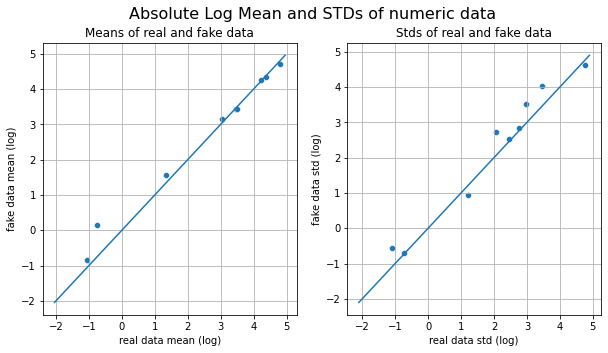

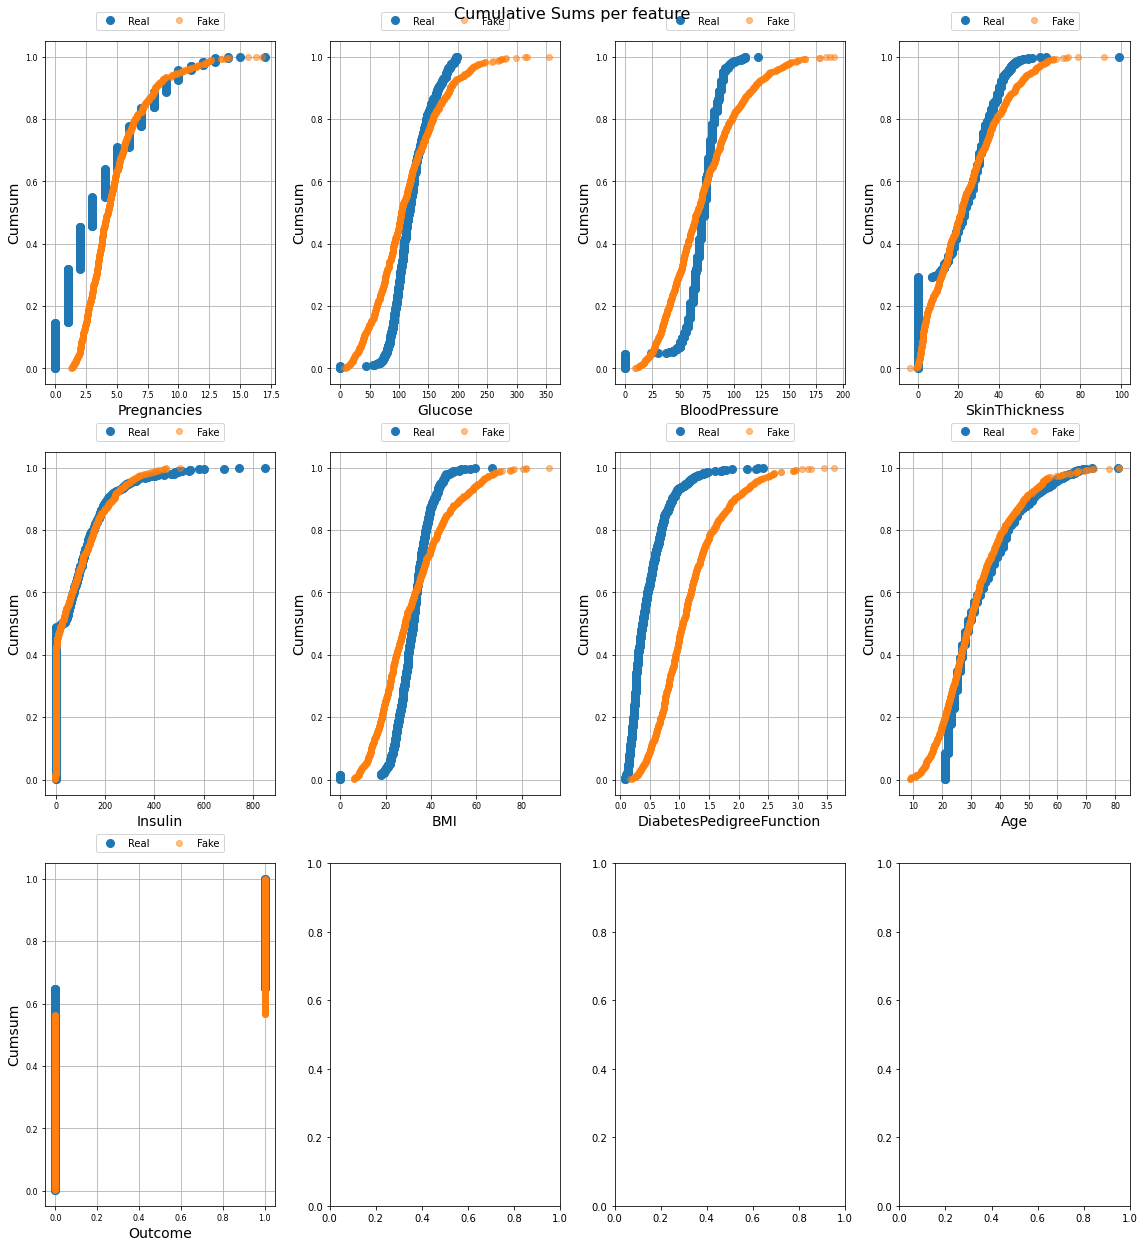

ValueError: ignored

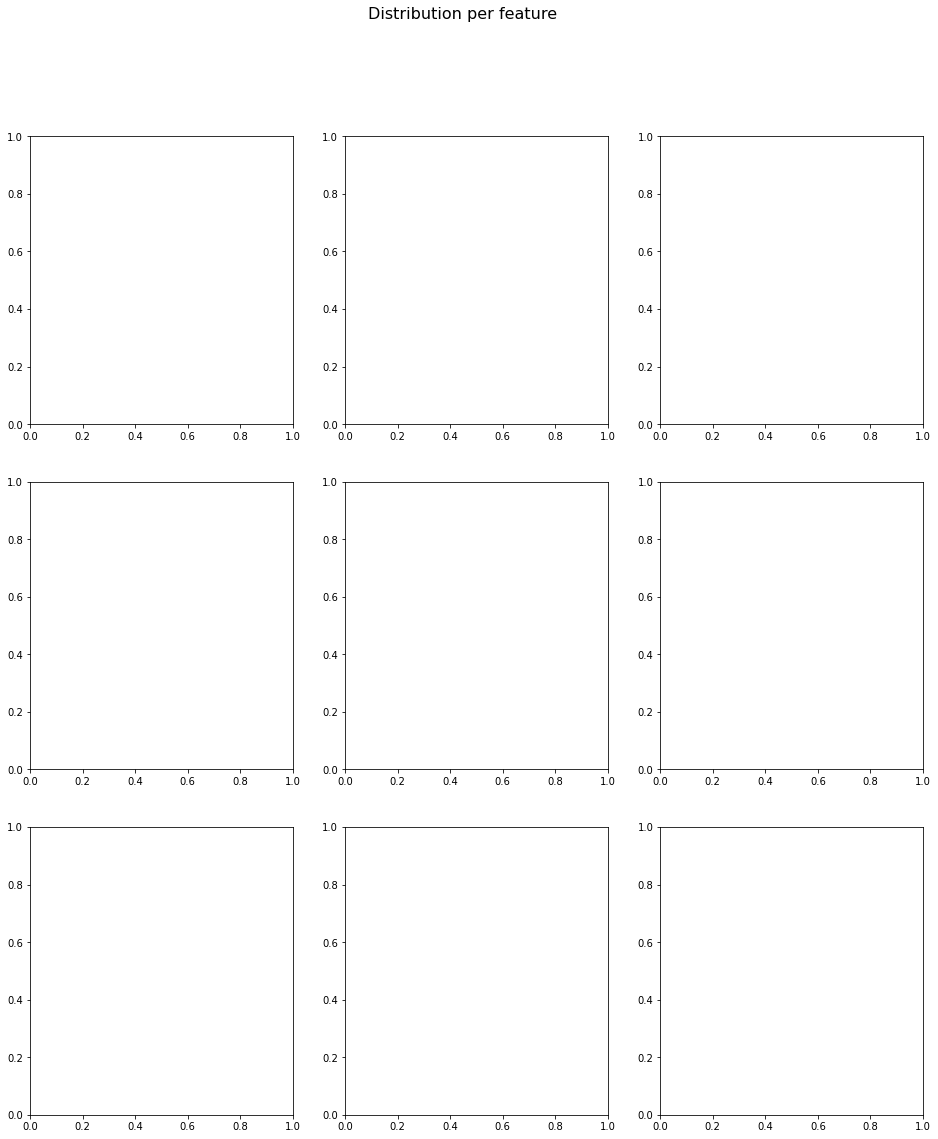